In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [6]:
train_model1 = pd.read_csv(r'../data/processed/model1_train_set.csv')
test_model1 = pd.read_csv(r'../data/processed/model1_test_set.csv')
train_model2 = pd.read_csv(r'../data/processed/model2_train_set.csv')
test_model2 = pd.read_csv(r'../data/processed/model2_test_set.csv')
train_model1_scaled = pd.read_csv(r'../data/processed/model1_train_set_scaled.csv')
test_model1_scaled = pd.read_csv(r'../data/processed/model1_test_set_scaled.csv')
train_model2_scaled = pd.read_csv(r'../data/processed/model2_train_set_scaled.csv')
test_model2_scaled = pd.read_csv(r'../data/processed/model2_test_set_scaled.csv')
test = pd.read_csv(r'../data/processed/final_test_set.csv')

# Model 1 (No Readmission vs Readmission)

## Feature Selection
The first method we tried to select features was to find linear correlations between the variables and our target variable

In [7]:
#Creating the correlaton matrix
correlation_matrix_model1 = train_model1.corr()
correlation_matrix_model2 = train_model2.corr()

#Focusing on correlations with our targets
correlations_with_readmission = correlation_matrix_model1['readmitted_general']
correlations_with_readmission_type= correlation_matrix_model2['readmitted_type']

#Sorting the correlations by the absolut value in descending order
sorted_correlations_with_readmission = correlations_with_readmission.abs().sort_values(ascending=False)
sorted_correlations_with_readmission_type = correlations_with_readmission_type.abs().sort_values(ascending=False)

#Looking for |correlations| > 0.5
print(sorted_correlations_with_readmission[sorted_correlations_with_readmission >=.5])
print(sorted_correlations_with_readmission_type[sorted_correlations_with_readmission_type >=.5])

readmitted_general    1.00000
readmitted            0.94909
Name: readmitted_general, dtype: float64
readmitted_type    1.0
readmitted         1.0
Name: readmitted_type, dtype: float64


We realized that there are not linear correlations between our features and our targets, which means that we need another feature selection strategy (non-linear way)

**Linear correlations between features**</br>

We also look for correlations between features as it may affect the models performance

**Correlations between features for general readmission model**

In [8]:
# Define the threshold for filtering
threshold = 0.6

# Create a mask to ignore self-correlation, converting DataFrame to numpy array first
mask = np.abs(correlation_matrix_model1.values) >  threshold  # Use .values to get numpy array
np.fill_diagonal(mask, False)

# Apply mask to find high correlations, convert mask back to DataFrame for where() operation
high_corr_pairs_model1 = correlation_matrix_model1.where(pd.DataFrame(mask, index=correlation_matrix_model1.index, columns=correlation_matrix_model1.columns))

# Stack the DataFrame and reset index to get pairings
stacked = high_corr_pairs_model1.stack().reset_index()
stacked.columns = ['Feature1', 'Feature2', 'Correlation']

# Filter out lower triangle to avoid duplicates
filtered_pairs_model1 = stacked[stacked['Feature1'] < stacked['Feature2']]

print(filtered_pairs_model1)

                  Feature1                    Feature2  Correlation
0               readmitted          readmitted_general     0.949090
1               readmitted             readmitted_type    -1.000000
3       max_glu_serum_Norm  max_glu_serum_Not measured    -0.694019
5             A1Cresult_>8      A1Cresult_Not measured    -0.660388
7             metformin_No            metformin_Steady    -0.950383
9           repaglinide_No          repaglinide_Steady    -0.948736
11          nateglinide_No          nateglinide_Steady    -0.970203
13       chlorpropamide_No       chlorpropamide_Steady    -0.964874
15          glimepiride_No          glimepiride_Steady    -0.948125
17            glipizide_No            glipizide_Steady    -0.943933
19            glyburide_No            glyburide_Steady    -0.927604
21         pioglitazone_No         pioglitazone_Steady    -0.973378
23        rosiglitazone_No        rosiglitazone_Steady    -0.980703
25             acarbose_No             acarbose_

**Correlations between features for readmission type model**

In [9]:
# Create a mask to ignore self-correlation, converting DataFrame to numpy array first
mask = np.abs(correlation_matrix_model2.values) >  threshold  # Use .values to get numpy array
np.fill_diagonal(mask, False)

# Apply mask to find high correlations, convert mask back to DataFrame for where() operation
high_corr_pairs_model2 = correlation_matrix_model2.where(pd.DataFrame(mask, index=correlation_matrix_model2.index, columns=correlation_matrix_model2.columns))

# Stack the DataFrame and reset index to get pairings
stacked = high_corr_pairs_model2.stack().reset_index()
stacked.columns = ['Feature1', 'Feature2', 'Correlation']

filtered_pairs_model2 = stacked[stacked['Feature1'] < stacked['Feature2']]

print(filtered_pairs_model2)

                  Feature1                    Feature2  Correlation
0               readmitted             readmitted_type    -1.000000
1       max_glu_serum_Norm  max_glu_serum_Not measured    -0.664747
3             A1Cresult_>8      A1Cresult_Not measured    -0.672175
5             metformin_No            metformin_Steady    -0.953311
7           repaglinide_No          repaglinide_Steady    -0.961045
9           nateglinide_No          nateglinide_Steady    -0.972069
11       chlorpropamide_No       chlorpropamide_Steady    -0.933193
13          glimepiride_No          glimepiride_Steady    -0.952133
15            glipizide_No            glipizide_Steady    -0.940691
17            glyburide_No            glyburide_Steady    -0.925724
19         pioglitazone_No         pioglitazone_Steady    -0.971395
21        rosiglitazone_No        rosiglitazone_Steady    -0.982794
23             acarbose_No             acarbose_Steady    -0.977936
25             miglitol_No             miglitol_

Strong correlations seem to be between the dummy encoded same features. This is a normal result, so we proceeded with the non-linear feature selection

For the non-linear feature selection strategy we decided to leverage the DecisionTree algorithm as a free feature selector utilizing the Random Forest algorithm. The logic behind the feature selection is virtually the same: the algorithms train with the provided data and assigns the importance to the features it used based on the information gain they obtained. This step consists of running the algorithms (for both models) without any imbalance handling nor hyperparameter tuning in order to establish a baseline subset of features for the following formal training.

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

#Define features and target for training
X1 = train_model1_scaled.drop(['readmitted_general'], axis=1)
y1 = train_model1_scaled['readmitted_general']

X2 = train_model2_scaled.drop(['readmitted_type'], axis=1)
y2 = train_model2_scaled['readmitted_type']

#Initialize the algorithm
rf_fs = RandomForestClassifier(random_state = 1)

########## MODEL 1 ################

#Fit
rf_fs = rf_fs.fit(X1, y1)

#Apply feature selection
rf_feature_selector1 = SelectFromModel(rf_fs, prefit=True)

#Store selected features
selected_features_rf1 = X1.columns[rf_feature_selector1.get_support()]

########## MODEL 2 ################

#Fit
rf_fs = rf_fs.fit(X2, y2)

#Apply feature selection
rf_feature_selector2 = SelectFromModel(rf_fs, prefit=True)

#Store selected features
selected_features_rf2 = X2.columns[rf_feature_selector2.get_support()]

print(f'Original features number = {X1.shape[1]} vs selected features = {len(selected_features_rf1)} for model 1')
print(f'Original features number = {X2.shape[1]} vs selected features = {len(selected_features_rf2)} for model 2')


Original features number = 181 vs selected features = 119 for model 1
Original features number = 181 vs selected features = 122 for model 2


# Models Training

## Handling imbalanced labels
 Before training our models, it was crucial to think about the significant challenge: predicting three possible classes with one being notably imbalanced. This imbalance was particularly impactful on our second model, tasked with determining if readmission would occur before or after 30 days. Specifically, the "<30 days" readmission category was underrepresented, necessitating effective strategies to mitigate this issue.

To counteract the imbalance, we deployed three approaches:

- **Random Oversampling:** This technique involves augmenting the minority class by randomly duplicating its samples until it matches the size of the majority class. This method aims to balance the dataset by increasing the presence of the underrepresented class.

- **Random Undersampling:** Contrary to oversampling, this method reduces the size of the majority class by randomly eliminating some of its samples to equal the quantity of the minority class. While this can help balance the classes, it also risks losing potentially valuable information.

- **SMOTE (Synthetic Minority Over-sampling Technique):** SMOTE is a more sophisticated approach that generates synthetic samples for the minority class. Instead of simply duplicating existing samples, it creates new ones by interpolating between several minority class samples that lie close together. This technique enables a more nuanced expansion of the dataset, potentially leading to enhanced model performance by producing a richer set of examples for the model to learn from. SMOTE can be particularly effective in cases where the minority class is not only underrepresented but also lacks diversity in its sample representation.

The best balancing method was selected by training each one, and then referencing our evaluation metrics to determine the optimal method.


In [11]:
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

late_readmitted=train_model2_scaled[(train_model2_scaled['readmitted_type']==0)]
early_readmitted=train_model2_scaled[(train_model2_scaled['readmitted_type']==1)]
#upsample minority
early_readmitted_upsampled = resample(early_readmitted,
                                     replace=True,
                                     n_samples=len(late_readmitted),
                                     random_state=27)
upsampled_train_model2 = pd.concat([late_readmitted, early_readmitted_upsampled]).sample(frac=1, 
                                                                                             random_state=10)\
    .reset_index(drop=True)

#Undersample majority
late_readmitted_downsampled = resample(late_readmitted,
                                      replace=False,
                                      n_samples=len(early_readmitted),
                                      random_state=27) # reproducible results
downsampled_train_model2 = pd.concat([late_readmitted_downsampled, early_readmitted]).sample(frac=1, 
                                                                                             random_state=10)\
    .reset_index(drop=True)

#SMOTE
X_smote2 = train_model2_scaled.drop(['readmitted_type'], axis=1)
y_smote2 = train_model2_scaled['readmitted_type']

smote = SMOTE(random_state=27)
X_resampled_smote2, y_resampled_smote2 = smote.fit_resample(X_smote2, y_smote2)

# Create a DataFrame from the resampled data
resampled_df_smote2 = pd.DataFrame(X_resampled_smote2, columns=X_smote2.columns)
resampled_df_smote2['readmitted_type'] = y_resampled_smote2

dfs2 = {'Without Balance':train_model2_scaled,
        'Upsampling minority':upsampled_train_model2, 
        'Undersampling majority':downsampled_train_model2, 
        'SMOTE':resampled_df_smote2}


/var/folders/_1/jzxxkx2s39l5jxsz34sqhj280000gn/T/ipykernel_18634/4246336690.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  resampled_df_smote2['readmitted_type'] = y_resampled_smote2


## Models training
The best performing models were Random Forests for both cases. To select the hyperparameters we performed cross validation with 5-fold methodology. We leveraged the RandomizedSearchCV tool from sci-kit learn, which randomly selects the number of combinations of the different parameters we set in the n_iter parameter. The algorithm selects the parameters based on the better performance in the metric we chose. This is computationally more efficient than traditional grid search because this second one uses every possible combination. </br>

We decided on two metrics: the main one, which our fine-tuning was based on was the AUC-ROC metric. This metric measures how well the models were able to distinguish between classes (No readmission or readmission for the first one and <30 or >30 in the second one) which represents the added value for the healthcare sector. The second one we aimed to optimize was the recall; identifying patients with real risk of readmission would have a higher positive impact regarding care of the patients and costs for the hospitals (based on our research the costs of inpatient care exceed the outpatient ones)

### Readmission vs No readmission model

Best model parameters: {'min_samples_split': 0.05, 'max_depth': 12}
Test AUC:  0.7
Test recall:  0.5
[[3236 1010]
 [1920 1746]]


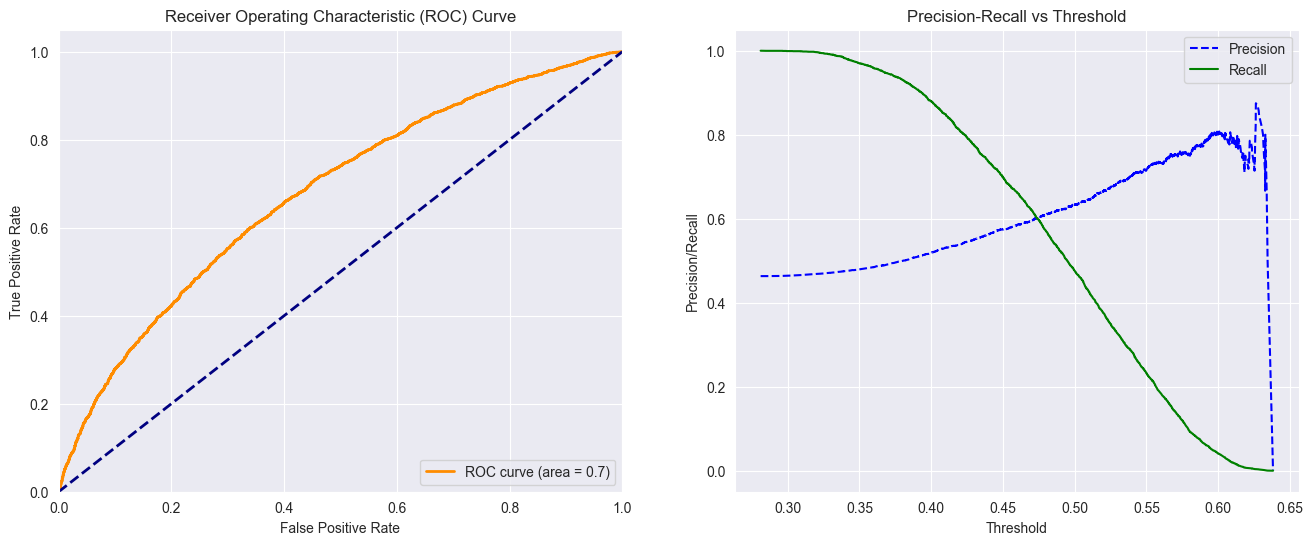

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import recall_score, confusion_matrix, precision_score, precision_recall_curve, roc_curve, roc_auc_score

#Setting hyperparameters
kf = KFold(n_splits=5, random_state=42, shuffle=True)
max_depths = [None] + [i for i in range(2,25)]
min_samples_splits = [i / 100 for i in range(5, 20)]
param_grid = {'max_depth':max_depths,
              'min_samples_split':min_samples_splits}

#Setting features and labels (train and test)
X_train1 = train_model1_scaled[selected_features_rf1]
y_train1 = train_model1_scaled['readmitted_general']
X_test1 = test_model1_scaled[selected_features_rf1]
y_test1 = test_model1_scaled['readmitted_general']

#Initializing the model and cv
rfc1= RandomForestClassifier(random_state=7) 
grid1 = RandomizedSearchCV(rfc1, param_grid, n_iter=20, cv=kf, scoring='roc_auc', n_jobs=-1, random_state=9)

#Fitting the model
grid1.fit(X_train1, y_train1)

#Compute test soft and hard predictions
y_test_prob1 = grid1.predict_proba(X_test1)[:, 1]
y_test_pred1 = grid1.predict(X_test1)

#Compute test metrics
precision_test1 = precision_score(y_test1,y_test_pred1)
recall_test1 = recall_score(y_test1, y_test_pred1)
cm_test1 = confusion_matrix(y_test1, y_test_pred1)
auc_test1 = roc_auc_score(y_test1, y_test_prob1)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test1, y_test_prob1)

#Compute precision-recall curve
precision, recall, thresholds_pr = precision_recall_curve(y_test1, y_test_prob1)

print(f'Best model parameters: {grid1.best_params_}')
print(f'Test AUC: {auc_test1: .1f}')
print(f'Test recall: {recall_test1: .1f}')
print(cm_test1)

# Create a figure for subplots
plt.figure(figsize=(16, 6))  # Adjust overall figure size

# Plot ROC curve on the left (1 row, 2 columns, first subplot)
plt.subplot(1, 2, 1)  # (rows, columns, subplot_index)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_test1:.1f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot Precision/Recall curve on the right (1 row, 2 columns, second subplot)
plt.subplot(1, 2, 2)  # (rows, columns, subplot_index)
plt.plot(thresholds_pr, precision[:-1], 'b--', label='Precision')
plt.plot(thresholds_pr, recall[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.title('Precision-Recall vs Threshold')
plt.legend(loc='best')
plt.grid(True)

# Show the combined figure with both subplots
plt.show()

As we have seen the AUC score is pretty decent for the proposed solution. In simple terms, our model has now overpassed a random choice from the population when differentiating between patients who are no readmitted and the ones who are. The precision/recall curve helps to identify how much we would sacrifice in precision metric in order to improve the recall. As we have mentioned, it is more valuable to identify the real readmissions, and the default threshold (.5)  only allows to identify half of them. This is why for final predictions we will set the threshold on .4 so that the model is actually able to identify more than 80% of the true readmissions.

### <30 VS >30 Days Readmission model
As previously mentioned, the training of this submodel faced an additional imbalance challenge, which was tackled by training models with the different types of resampling. For the training of each model the same parameter grid and Cross Validation process were performed. The best performing resampled df was then used to train the final model

In [13]:
X_test2 = test_model2_scaled[selected_features_rf2]
y_test2 = test_model2_scaled['readmitted_type']

#Iterating on all the resamplings and the original without resampling as well
for key, dframe in dfs2.items():
    X_train2 = dframe[selected_features_rf2]
    y_train2 = dframe['readmitted_type']
    
    rfc2= RandomForestClassifier(random_state=17)
    
    grid = RandomizedSearchCV(rfc2, param_grid, n_iter=20, cv=kf, scoring='roc_auc', n_jobs=-1, random_state=20)
    grid.fit(X_train2, y_train2)
    
    y_test_pred2 = grid.predict(X_test2)
    precision_test2 = precision_score(y_test2,y_test_pred2)
    recall_test2 = recall_score(y_test2, y_test_pred2)
    cm_test2 = confusion_matrix(y_test2, y_test_pred2)
    
    print(f'Model with {key}')
    print(grid.best_params_)
    print(grid.best_score_)
    print(f'Test recall = {recall_test2}')
    print(f'Test precision = {precision_test2}')
    print(cm_test2)

/Users/diegoleon/Documents/DLR/Madrid/IE/2nd Term/Machine Learning 2/Group project/diabetes-readmission-prediction/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model with Without Balance
{'min_samples_split': 0.06, 'max_depth': 14}
0.5985698910582791
Test recall = 0.0
Test precision = 0.0
[[5593    0]
 [1752    0]]
Model with Upsampling minority
{'min_samples_split': 0.05, 'max_depth': 12}
0.6394159926062462
Test recall = 0.5490867579908676
Test precision = 0.3103225806451613
[[3455 2138]
 [ 790  962]]
Model with Undersampling majority
{'min_samples_split': 0.06, 'max_depth': 22}
0.5921165073835258
Test recall = 0.5593607305936074
Test precision = 0.29589371980676327
[[3261 2332]
 [ 772  980]]
Model with SMOTE
{'min_samples_split': 0.05, 'max_depth': 12}
0.8495710724473003
Test recall = 0.20034246575342465
Test precision = 0.334604385128694
[[4895  698]
 [1401  351]]


In general terms, the best-performing resample is random oversampling of the minority class. SMOTE technique seems to overfit as the training score looks good but testing metrics are poor. This is why the final second submodel will be trained with the oversample technique.

Best model parameters: {'min_samples_split': 0.05, 'max_depth': None}
Test AUC:  0.6
Test recall:  0.5
[[3453 2140]
 [ 797  955]]


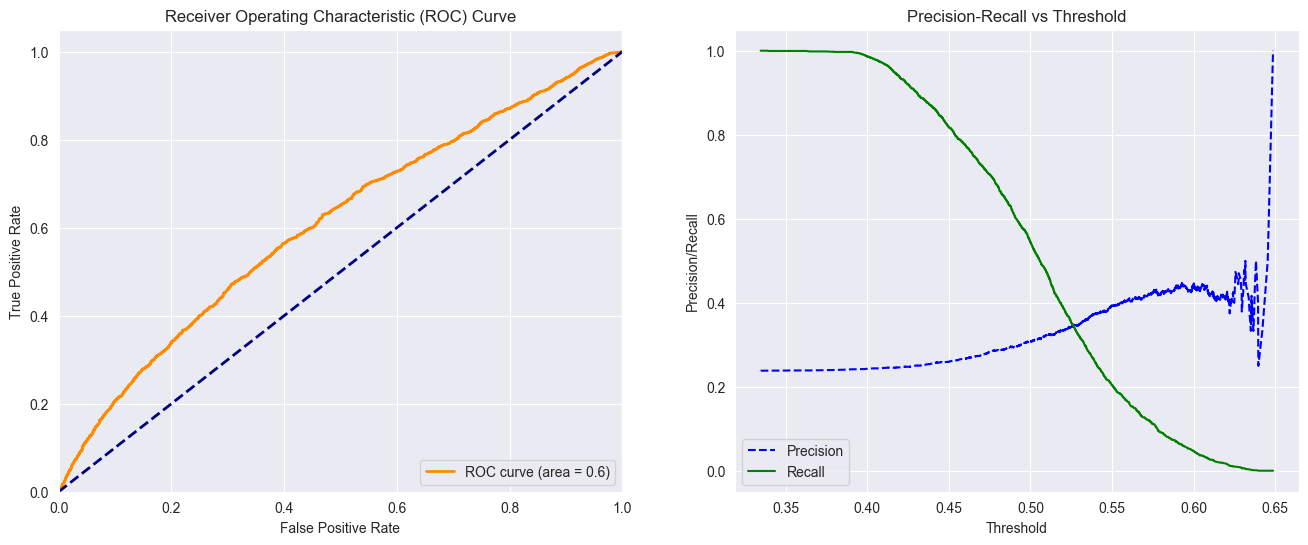

In [14]:
#from sklearn.metrics import precision_recall_curve
X_train2 = upsampled_train_model2[selected_features_rf2]
y_train2 = upsampled_train_model2['readmitted_type']
X_test2 = test_model2_scaled[selected_features_rf2]
y_test2 = test_model2_scaled['readmitted_type'] 

    
#Initializing the model and cv
rfc2= RandomForestClassifier(random_state=17)
grid2 = RandomizedSearchCV(rfc2, param_grid, n_iter=20, cv=kf, scoring='roc_auc', n_jobs=-1, random_state=8)

#Fitting the model
grid2.fit(X_train2, y_train2)

#Compute test soft and hard predictions
y_test_prob2 = grid2.predict_proba(X_test2)[:, 1]
y_test_pred2 = grid2.predict(X_test2)

#Compute test metrics
precision_test2 = precision_score(y_test2,y_test_pred2)
recall_test2 = recall_score(y_test2, y_test_pred2)
cm_test2 = confusion_matrix(y_test2, y_test_pred2)
auc_test2 = roc_auc_score(y_test2, y_test_prob2)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test2, y_test_prob2)

#Compute precision-recall curve
precision, recall, thresholds_pr = precision_recall_curve(y_test2, y_test_prob2)

print(f'Best model parameters: {grid2.best_params_}')
print(f'Test AUC: {auc_test2: .1f}')
print(f'Test recall: {recall_test2: .1f}')
print(cm_test2)

# Create a figure for subplots
plt.figure(figsize=(16, 6))  # Adjust overall figure size

# Plot ROC curve on the left (1 row, 2 columns, first subplot)
plt.subplot(1, 2, 1)  # (rows, columns, subplot_index)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_test2:.1f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot Precision/Recall curve on the right (1 row, 2 columns, second subplot)
plt.subplot(1, 2, 2)  # (rows, columns, subplot_index)
plt.plot(thresholds_pr, precision[:-1], 'b--', label='Precision')
plt.plot(thresholds_pr, recall[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.title('Precision-Recall vs Threshold')
plt.legend(loc='best')
plt.grid(True)

# Show the combined figure with both subplots
plt.show()

Visually speaking, the second submodel interpretation resembles the first model. However, it seems that with the exisiting data about encounters and patients, the algorithm struggles more to find differences between early and late readmissions. In terms of general performance it does not seem to help us to reach the objectives but it is a fact we need to highlight. In a similar way, to optimize the performance and achieve a better optimization in our metrics, we have decided to change the threshold to 0.45. It does not seem as a significant change, but it actually reaches a test recall of 80% which means that, inside the readmissions, the model would be able to identify 80% of real early ones. Conversely, precision is more sensitive to changes in the threshold, which is the "price" we are paying in order to improve the recall.

# Models bagging (Final Prediction)
Now we are going to test the bagging of both models with unseen data: the original test split that have not been used at all for training

First we need to transform test set according to the developed Pipeline

In [16]:
import sys
import os
module_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'data'))

if module_path not in sys.path:
    sys.path.append(module_path)
from data_processing_pipeline import impact_encoding_model1, impact_encoding_model2, scaler1, scaler2, features_model1, features_model2, no_scale_model1, no_scale_model2

final_test_model1 = test.copy()
final_test_model2 = test.copy()

#Applying encodings
impact_encoding_model1(final_test_model1)
impact_encoding_model2(final_test_model2)

#Applying scalers
final_test_model1_scaled = scaler1.transform(final_test_model1[features_model1])
final_test_model2_scaled = scaler2.transform(final_test_model2[features_model2])

#Returning to dfs
final_test_model1_scaled = pd.DataFrame(final_test_model1_scaled, columns=features_model1)
final_test_model2_scaled = pd.DataFrame(final_test_model2_scaled, columns=features_model2)

# Assign the values from the original DataFrames targets
# And explicitly set the data type to match the original DataFrames

for col in no_scale_model1:
    final_test_model1_scaled[col] = final_test_model1[col].values.astype(final_test_model1[col].dtype)
    
for col in no_scale_model2:
    final_test_model2_scaled[col] = final_test_model2[col].values.astype(final_test_model2[col].dtype)

In [17]:
final_test_model1_scaled.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,...,miglitol_Up,insulin_Down,insulin_No,insulin_Steady,insulin_Up,glyburide-metformin_Down,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,readmitted_general
0,0.366846,0.916728,1.183437,0.689303,-0.508262,-1.196562,-0.040188,0.984544,0.494762,0.695701,...,-0.0053,-0.36308,1.049702,-0.658217,-0.343385,-0.00918,0.083159,-0.082212,-0.00838,0
1,0.366846,-1.090836,0.558210,-0.691475,0.447600,0.288149,-0.423811,-1.015699,-0.692545,-0.046379,...,-0.0053,-0.36308,-0.952651,1.519255,-0.343385,-0.00918,0.083159,-0.082212,-0.00838,1
2,0.366846,-1.090836,-0.692245,-0.691475,-0.508262,0.288149,-0.423811,0.984544,1.217471,-0.788459,...,-0.0053,-0.36308,1.049702,-0.658217,-0.343385,-0.00918,0.083159,-0.082212,-0.00838,0
3,0.366846,0.916728,1.183437,0.689303,-0.125917,-1.196562,-0.423811,-1.015699,1.217471,-0.788459,...,-0.0053,-0.36308,-0.952651,-0.658217,2.912186,-0.00918,0.083159,-0.082212,-0.00838,0
4,0.366846,0.916728,1.808665,-0.691475,2.741670,0.288149,1.494302,-1.015699,0.546384,-0.046379,...,-0.0053,-0.36308,1.049702,-0.658217,-0.343385,-0.00918,0.083159,-0.082212,-0.00838,0


In [18]:
final_test_model2_scaled.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,...,miglitol_Up,insulin_Down,insulin_No,insulin_Steady,insulin_Up,glyburide-metformin_Down,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,readmitted_type
0,-0.420108,0.898882,1.175061,0.669161,-0.505472,-1.244680,-0.105133,1.026703,0.452747,0.746910,...,-0.005834,-0.394536,1.109740,-0.649702,-0.369907,0.0,0.086063,-0.085862,-0.005834,NaN
1,-0.420108,-1.112494,0.536647,-0.676904,0.463366,0.250575,-0.486537,-0.973992,-0.742752,-0.008277,...,-0.005834,-0.394536,-0.901112,1.539168,-0.369907,0.0,0.086063,-0.085862,-0.005834,0.0
2,-0.420108,-1.112494,-0.740180,-0.676904,-0.505472,0.250575,-0.486537,1.026703,1.180443,-0.763465,...,-0.005834,-0.394536,1.109740,-0.649702,-0.369907,0.0,0.086063,-0.085862,-0.005834,NaN
3,-0.420108,0.898882,1.175061,0.669161,-0.117937,-1.244680,-0.486537,-0.973992,1.180443,-0.763465,...,-0.005834,-0.394536,-0.901112,-0.649702,2.703379,0.0,0.086063,-0.085862,-0.005834,NaN
4,-0.420108,0.898882,1.813475,-0.676904,2.788577,0.250575,1.420482,-0.973992,0.504726,-0.008277,...,-0.005834,-0.394536,1.109740,-0.649702,-0.369907,0.0,0.086063,-0.085862,-0.005834,NaN


**Predictions**

In [19]:
#Setting test Xs and ys
X_final_test1 = final_test_model1_scaled[selected_features_rf1]
y_final_test1 = final_test_model1_scaled['readmitted_general']
X_final_test2 = final_test_model2_scaled[selected_features_rf2]
y_final_test2 = final_test_model2_scaled['readmitted_type']

#Setting defined thresholds for hard predictions
threshold1= 0.4
threshold2= 0.45

#Predictions
y_final_test_prob1 = grid1.predict_proba(X_final_test1)[:, 1]
y_final_test_pred1 = (y_final_test_prob1 >= threshold1).astype(int)
y_final_test_prob2 = grid2.predict_proba(X_final_test2)[:, 1]
y_final_test_pred2 = (y_final_test_prob1 >= threshold2).astype(int)

#Adding predictions to test
test['model1_pred'] = y_final_test_pred1
test['model2_pred'] = y_final_test_pred2

#Creating bagged prediction
conditions = [
    test['model1_pred'] == 0,  # Condition for model1_pred == 1
    test['model2_pred'] == 1   # Condition for model2_pred == 1
]

choices = [
    0,  # Choice for model1_pred == 0
    1   # Choice for model2_pred == 1
]
default = 2
test['final_prediction'] = np.select(conditions, choices, default=default)

**Evaluation**

The evaluation consists of initially assessing how the model does in terms of readmission or no readmission and then as whole (the 3 labels)

AUC-ROC score: 0.7
Recall: 0.9


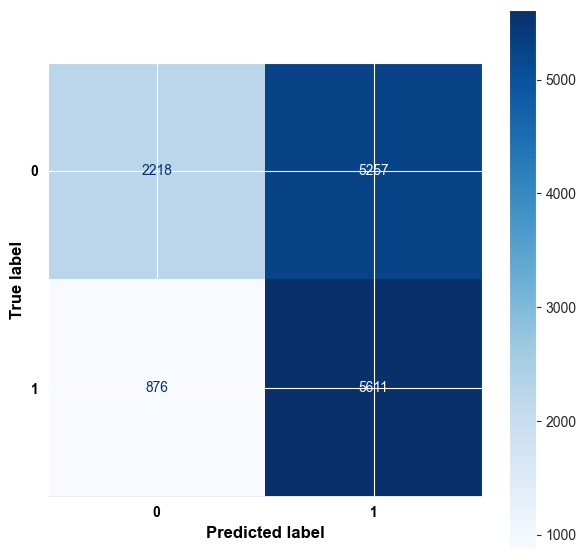

In [20]:
#Readmission vs No readmission performance
from sklearn.metrics import ConfusionMatrixDisplay
print(f'AUC-ROC score: {roc_auc_score(test["readmitted_general"], y_final_test_prob1):.1f}')
print(f'Recall: {recall_score(test["readmitted_general"], test["model1_pred"]):.1f}')
cm = confusion_matrix(test["readmitted_general"], y_final_test_pred1, labels=grid1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=grid1.classes_)

# Customize the plot
fig, ax = plt.subplots(figsize=(7, 7))  # Adjust the figure size as needed
disp.plot(cmap='Blues', ax=ax)  # Use a well-defined color palette (e.g., 'Blues', 'viridis')

# Customizing plot
ax.set_xlabel('Predicted label', fontsize=12, weight='bold', color='black')
ax.set_ylabel('True label', fontsize=12, weight='bold', color='black')
ax.set_xticklabels(grid1.classes_, fontsize=10, weight='bold', color='black')
ax.set_yticklabels(grid1.classes_, fontsize=10, weight='bold', color='black')

plt.show()


Final test performance in first submodel seems to be consistent with seen results in training and sub-test. We reached acceptable results in terms of identifying readmissions.

              precision    recall  f1-score   support

           0       0.72      0.30      0.42      7475
           1       0.14      0.69      0.24      1582
           2       0.29      0.19      0.23      4905

    accuracy                           0.30     13962
   macro avg       0.38      0.39      0.30     13962
weighted avg       0.50      0.30      0.33     13962


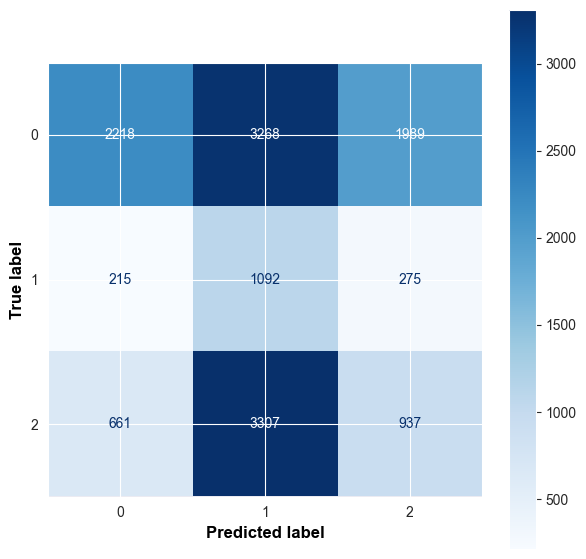

In [21]:
# Overall performance for the three labels
from sklearn.metrics import classification_report, accuracy_score

print(classification_report(test['readmitted'], test['final_prediction']))
cm = confusion_matrix(test['readmitted'], test['final_prediction'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Customize the plot
fig, ax = plt.subplots(figsize=(7, 7))  # Adjust the figure size as needed
disp.plot(cmap='Blues', ax=ax)  # Use a well-defined color palette (e.g., 'Blues', 'viridis')

# Customizing plot
ax.set_xlabel('Predicted label', fontsize=12, weight='bold', color='black')
ax.set_ylabel('True label', fontsize=12, weight='bold', color='black')

plt.show()


The performance of the overall algorithm fulfills the objectives in terms of predicting readmissions (early ones mainly). This is result of the priority and optimization allocated during solution development. When assessing the model based on how well it distinguished between the 3 classes it is noticeable that it may have improvements. 
It is clear that the deployed algorithms grapple with discerning the type of readmission that a patient could have. Moreover, as a first approach, predicting accurate readmissions will definitely be useful for decreasing related costs and improving the patient care with more personalized preventive actions (as opposed to the current reactive strategy).

# Conclusion

- Our project developed a two-step binary classification algorithm to predict hospital readmissions among diabetic patients, focused on optimizing AUC-ROC scores and recall to accurately identify true positives, especially early readmissions.
- The first submodel successfully differentiates between readmission and no readmission cases, while the second submodel distinguishes between readmissions occurring in less than 30 days versus more than 30 days.
- Individually, both submodels perform well, with a particular strength in identifying actual readmissions and, more specifically, early readmissions (<30 days), aligning with our goal to prioritize early detection.
- The overall model's performance is more effective in predicting early readmissions, with the majority of errors occurring in predicting the >30 days readmissions category. This outcome was anticipated due to the focus on early readmission detection during the model training process.
- Accurately predicting readmissions as a whole can significantly contribute to reducing direct healthcare costs associated with diabetic patient readmissions by enabling hospitals to allocate resources more effectively and implement targeted interventions.
- Moreover, the model facilitates insights into patient care by highlighting the need for more personalized and preventive actions, improving patient outcomes through early intervention and support.

# Recommendations for Future Work

- **Data Collection and Feature Engineering**: Explore the collection of additional features, such as time to readmission, patient lifestyle factors, and more detailed medical history, to improve the model's ability to distinguish between different readmission time frames.
- **Model Refinement**: Investigate advanced machine learning techniques and algorithms that may offer improved performance, especially for predicting >30 days readmissions.
- **Focus on >30 Days Readmissions**: Given the current model's challenges in accurately predicting >30 days readmissions, future efforts could specifically target enhancing performance in this area through targeted feature selection and algorithm adjustments.
- **Integration with Healthcare Systems**: Work on developing a seamless integration framework for the model within existing healthcare IT ecosystems to facilitate real-time predictions and interventions.
- **Patient-Centric Approaches**: Incorporate patient feedback and outcomes into the model to refine its predictive capabilities further and ensure it addresses the most relevant factors affecting readmission risks.
- **Continuous Monitoring and Updating**: Establish a mechanism for continuous model evaluation and updating based on new data and evolving healthcare practices to maintain its relevance and effectiveness over time.
